In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from textblob import TextBlob
import wordcloud
import gensim.downloader as gensim_api

In [6]:
df1 = pd.read_csv("df1")
df2 = pd.read_csv("df2")
df3 = pd.read_csv("df3")
df4 = pd.read_csv("df4")
df5 = pd.read_csv("df5")

In [7]:
df = pd.concat([df1, df2, df3, df4, df5])

In [9]:
df.to_csv("final_df.csv")

In [13]:
df.head()

,Unnamed: 0,review,main_review,rating
0,0,Best Earbuds,The Quality And Design of the Earbuds are so g...,5.0
1,1,Amezing product P tron,True Wireless Bluetooth Headphones(TWS) with i...,5.0
2,2,Best purchase😍,Sound quality is so good.. Pocket friendly wi...,5.0
3,3,Best quality earbuds,Bassbuds connects really well even from a good...,5.0
4,4,Replace if you get defective piece,Initially gave 2 stars for first one. They so...,5.0


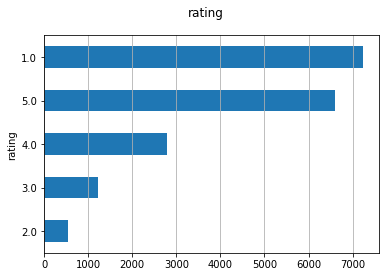

In [18]:
x = "rating"
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
df[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

Data is imbalanced. We can use class weight balance or we can use undersampling and oversampling of the data to balance the data.

In [15]:
df.shape

(18383, 4)

## Language Prediction

Since the used can comment in any of the local language. In that case it is important for us to detect the language of the comment.

In [21]:
import langdetect

In [40]:
# detecting the language of the reivew
for i in range(df.shape[0]):
    try:
        df["lang"] = langdetect.detect(df["review"].iloc[i])
    except:
        df["lang"].iloc[i] = "unknown"

C:\Users\Surjeet\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [41]:
df.head()

,Unnamed: 0,review,main_review,rating,lang
0,0,Best Earbuds,The Quality And Design of the Earbuds are so g...,5.0,en
1,1,Amezing product P tron,True Wireless Bluetooth Headphones(TWS) with i...,5.0,en
2,2,Best purchase😍,Sound quality is so good.. Pocket friendly wi...,5.0,en
3,3,Best quality earbuds,Bassbuds connects really well even from a good...,5.0,en
4,4,Replace if you get defective piece,Initially gave 2 stars for first one. They so...,5.0,en


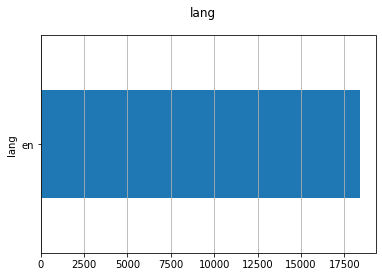

In [42]:
# plot of different languages
x = "lang"
fig, ax = plt.subplots()
fig.suptitle(x, fontsize=12)
df[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The language of the all the comments is english.

In [44]:
df = df[df["lang"]=="en"]

Some of the words are not important in the rating prediction. These are the words which are present in every text such as "the", "a", "it". In the NLP lingo, these words are known as stop words and we have to remove those words. Furhtermore, we have to stem the words. For example the word "wash" have same action as "washing". In the given text, "washing" will be changed to "wash".

In [61]:
stopwords = nltk.corpus.stopwords.words("english")
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, stopwords=stopwords):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [65]:
# cleaning the text, removing stopwords, stemming
stopwords = nltk.corpus.stopwords.words("english")
df["clean_review"] = df["review"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))
df["clean_main_review"] = df["main_review"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True))

In [69]:
df.drop(["Unnamed: 0"], inplace=True, axis = 1)

We will extract the word count, characted count of every review so that we can analyzes by the length of the comment.

In [73]:
# extracting the word counts, character counts, sentence count for each reivew
df['rev_w_count'] = df["clean_review"].apply(lambda x: len(str(x).split(" ")))
df['main_rev_w_count'] = df["clean_main_review"].apply(lambda x: len(str(x).split(" ")))
df['rev_char_count'] = df["clean_review"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['main_rev_char_count'] = df["clean_main_review"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
df['sentence_count'] = df["clean_main_review"].apply(lambda x: len(str(x).split(".")))
df['avg_word_length'] = df['main_rev_char_count'] / df['main_rev_w_count']
df['avg_sentence_lenght'] = df['main_rev_w_count'] / df['sentence_count']
df.head()

,review,main_review,rating,lang,clean_review,clean_main_review,rev_w_count,main_rev_w_count,rev_char_count,main_rev_char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,Best Earbuds,The Quality And Design of the Earbuds are so g...,5.0,en,best earbuds,quality design earbuds good feel like premium ...,2,27,11,175,1,6.481481,27.0
1,Amezing product P tron,True Wireless Bluetooth Headphones(TWS) with i...,5.0,en,amezing product p tron,true wireless bluetooth headphonestws immersiv...,4,86,19,559,1,6.500000,86.0
2,Best purchase😍,Sound quality is so good.. Pocket friendly wi...,5.0,en,best purchase,sound quality good pocket friendly wireless ea...,2,46,12,260,1,5.652174,46.0
3,Best quality earbuds,Bassbuds connects really well even from a good...,5.0,en,best quality earbuds,bassbuds connects really well even good distan...,3,42,18,242,1,5.761905,42.0
4,Replace if you get defective piece,Initially gave 2 stars for first one. They so...,5.0,en,replace get defective piece,initially gave 2 star first one sold used one ...,4,119,24,623,1,5.235294,119.0


In [74]:
# dropping the raw reivew
df.drop(["review", "main_review"], inplace = True, axis = 1)

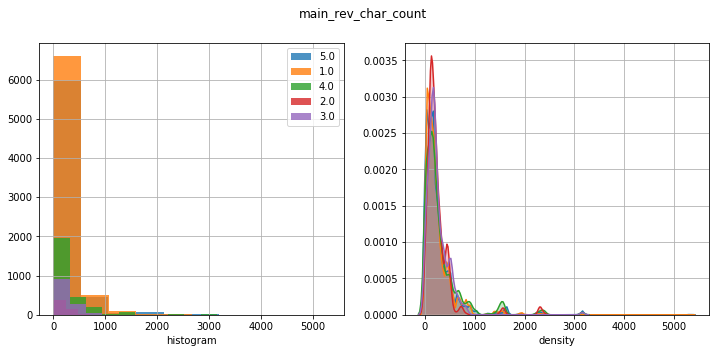

In [85]:
x, y = "main_rev_char_count", "rating"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
fig.suptitle(x, fontsize=12)
#fig.size(10,5)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, 
                 bins=10, hist_kws={"alpha":0.8}, 
                 axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, 
                 kde_kws={"shade":True}, axlabel="density",   
                 ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.show()

As it is clear from the density plot, the maximum review have length between 0 to 2000. The reviews that has larger character length can be considered as outliers and we can filter that data.

We will also analyze the sentiment of the review by using some pretrained model such as TextBlob.

In [93]:
# adding the sentiment of the reivew
df["sentiment"] = df['clean_main_review'].apply(lambda x: TextBlob(x).sentiment.polarity)

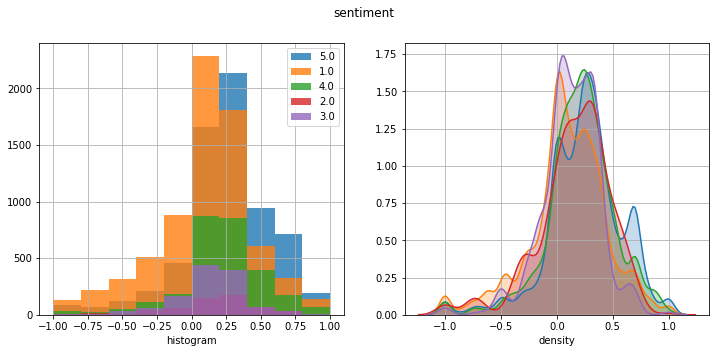

In [97]:
x, y = "sentiment", "rating"
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,5))
fig.suptitle(x, fontsize=12)
#fig.size(10,5)
for i in df[y].unique():
    sns.distplot(df[df[y]==i][x], hist=True, kde=False, bins=10, hist_kws={"alpha":0.8}, axlabel="histogram", ax=ax[0])
    sns.distplot(df[df[y]==i][x], hist=False, kde=True, kde_kws={"shade":True}, axlabel="density", ax=ax[1])
ax[0].grid(True)
ax[0].legend(df[y].unique())
ax[1].grid(True)
plt.show()

We can see from the graph that the reviews with low rating has negative sentiment whereas the review with the high rating has positive sentiments.

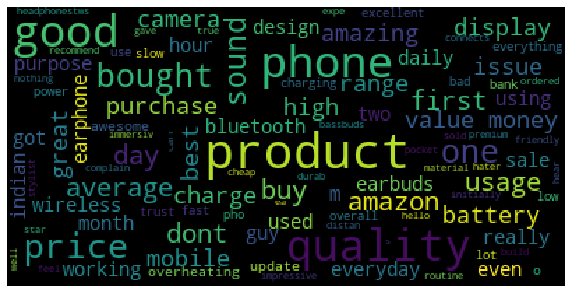

In [111]:
# making the word cloud of the 100 important words of the reivew
wc = wordcloud.WordCloud(background_color='black', max_words=100, max_font_size=35)
corpus = df["clean_main_review"]
wc = wc.generate(str(corpus))
fig = plt.figure(figsize=(10,7))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [2]:
nlp = gensim_api.load("glove-wiki-gigaword-300")

In [114]:
import gensim

In [ ]:
df.to_csv("cleaned_df.csv")

In [4]:
df = pd.read_csv("cleaned_df.csv")

In [5]:
df.drop(["Unnamed: 0"], inplace = True, axis = 1)
df.head()

,rating,lang,clean_review,clean_main_review,rev_w_count,main_rev_w_count,rev_char_count,main_rev_char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
0,5.0,en,best earbuds,quality design earbuds good feel like premium ...,2,27,11,175,1,6.481481,27.0,0.566667
1,5.0,en,amezing product p tron,true wireless bluetooth headphonestws immersiv...,4,86,19,559,1,6.500000,86.0,0.146349
2,5.0,en,best purchase,sound quality good pocket friendly wireless ea...,2,46,12,260,1,5.652174,46.0,0.406955
3,5.0,en,best quality earbuds,bassbuds connects really well even good distan...,3,42,18,242,1,5.761905,42.0,0.543590
4,5.0,en,replace get defective piece,initially gave 2 star first one sold used one ...,4,119,24,623,1,5.235294,119.0,0.195985


In [6]:
dtf = df[df["main_rev_char_count"]<1500] 

We will use tfidf to vectorize the text data.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [8]:
tfidf = TfidfVectorizer(max_features = 20000, ngram_range=(1,3), analyzer = "char")

In [9]:
#X = tfidf.fit_transform(df["clean_main_review"])
X = tfidf.fit_transform(dtf['clean_main_review'].values.astype('U'))
y = dtf['rating']

In [10]:
X.shape, y.shape

((18027, 7332), (18027,))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Linear SVC

In [12]:
LSVC = LinearSVC(C = 10, class_weight = "balanced", max_iter = 20000)
LSVC.fit(X_train, y_train)
y_pred = LSVC.predict(X_test)

In [14]:
X_train.shape

(3677, 8055)

In [13]:
y_pred = LSVC.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.65      0.51      0.57      1449
         2.0       0.25      0.67      0.36       108
         3.0       0.36      0.67      0.47       249
         4.0       0.35      0.46      0.40       495
         5.0       0.64      0.53      0.58      1305

    accuracy                           0.53      3606
   macro avg       0.45      0.57      0.48      3606
weighted avg       0.57      0.53      0.54      3606



## Decision Tree Classifier

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
DT = DecisionTreeClassifier(class_weight = 'balanced')
DT.fit(X_train, y_train)
y_pred_DT = DT.predict(X_test)

In [16]:
print(classification_report(y_test, y_pred_DT))

              precision    recall  f1-score   support

         1.0       0.70      0.39      0.50      1449
         2.0       0.18      0.81      0.30       108
         3.0       0.32      0.72      0.45       249
         4.0       0.31      0.59      0.41       495
         5.0       0.65      0.41      0.50      1305

    accuracy                           0.46      3606
   macro avg       0.43      0.58      0.43      3606
weighted avg       0.59      0.46      0.48      3606



## Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [18]:
RF = RandomForestClassifier(class_weight = "balanced")
RF.fit(X_train, y_train)
y_predRF = RF.predict(X_test)

In [19]:
print(classification_report(y_test, y_predRF))

              precision    recall  f1-score   support

         1.0       0.69      0.42      0.52      1449
         2.0       0.21      0.79      0.33       108
         3.0       0.34      0.72      0.46       249
         4.0       0.32      0.57      0.41       495
         5.0       0.65      0.44      0.53      1305

    accuracy                           0.48      3606
   macro avg       0.44      0.59      0.45      3606
weighted avg       0.59      0.48      0.50      3606



## Naive Bayes

In [20]:
from sklearn.naive_bayes import MultinomialNB

In [24]:
NB = MultinomialNB()
NB.fit(X_train, y_train)
y_predNB = NB.predict(X_test)

In [25]:
print(classification_report(y_test, y_predNB))

              precision    recall  f1-score   support

         1.0       0.54      0.74      0.63      1449
         2.0       0.00      0.00      0.00       108
         3.0       0.83      0.14      0.23       249
         4.0       0.39      0.04      0.08       495
         5.0       0.55      0.63      0.58      1305

    accuracy                           0.54      3606
   macro avg       0.46      0.31      0.30      3606
weighted avg       0.53      0.54      0.49      3606



In [46]:
from sklearn.ensemble import RandomForestRegressor

In [52]:
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)
y_predRFR = RFR.predict(X_test)

In [50]:
RFR.score(X_test, y_test)

0.4769828064337216